In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, GlobalMaxPool1D, Embedding, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv("/content/drive/MyDrive/TensorFlow/Restaurant Reviews/Restaurant reviews.csv")
df_tmp = df[["Review", "Rating"]]

In [4]:
df_tmp["Rating"].value_counts()

5       3832
4       2373
1       1735
3       1193
2        684
4.5       69
3.5       47
2.5       19
1.5        9
Like       1
Name: Rating, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Restaurant  10000 non-null  object 
 1   Reviewer    9962 non-null   object 
 2   Review      9955 non-null   object 
 3   Rating      9962 non-null   object 
 4   Metadata    9962 non-null   object 
 5   Time        9962 non-null   object 
 6   Pictures    10000 non-null  int64  
 7   7514        1 non-null      float64
dtypes: float64(1), int64(1), object(6)
memory usage: 625.1+ KB


In [6]:
df_tmp.drop(index = 7601, axis =0, inplace = True)

<ipython-input-6-faf55d017d13>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.drop(index = 7601, axis =0, inplace = True)


In [7]:
df_tmp["Rating"] = df_tmp["Rating"].astype(float)

<ipython-input-7-67d2c7b7b053>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["Rating"] = df_tmp["Rating"].astype(float)


In [8]:
df_tmp.loc[df_tmp["Rating"] > 3, "Sentiment"] = "Positive"
df_tmp.loc[df_tmp["Rating"] <= 3, "Sentiment"] = "Negative"

<ipython-input-8-bca94e70d5aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.loc[df_tmp["Rating"] > 3, "Sentiment"] = "Positive"


In [9]:
df_tmp

,Review,Rating,Sentiment
0,"The ambience was good, food was quite good . h...",5.0,Positive
1,Ambience is too good for a pleasant evening. S...,5.0,Positive
2,A must try.. great food great ambience. Thnx f...,5.0,Positive
3,Soumen das and Arun was a great guy. Only beca...,5.0,Positive
4,Food is good.we ordered Kodi drumsticks and ba...,5.0,Positive
...,...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,3.0,Negative
9996,This place has never disappointed us.. The foo...,4.5,Positive
9997,"Bad rating is mainly because of ""Chicken Bone ...",1.5,Negative
9998,I personally love and prefer Chinese Food. Had...,4.0,Positive


<Axes: xlabel='Sentiment', ylabel='count'>

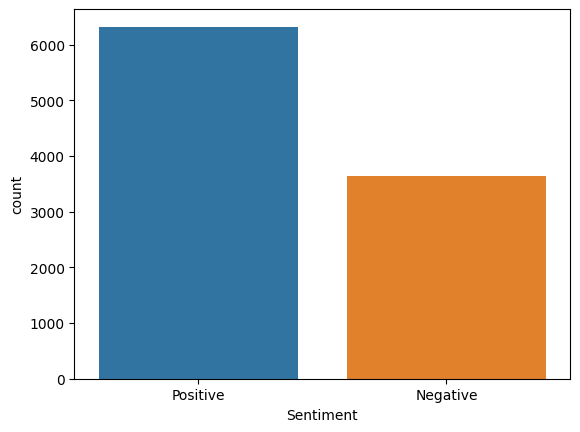

In [10]:
import seaborn as sns
sns.countplot(df_tmp, x = "Sentiment")

In [11]:
nlp_data = df_tmp[["Review", "Sentiment"]]
nlp_data["Sentiment"] = nlp_data["Sentiment"].replace({
    "Positive": 1,
    "Negative": 0
})
positive = nlp_data.loc[nlp_data["Sentiment"] == 1][:500]
negative = nlp_data.loc[nlp_data["Sentiment"] == 0][:500]
nlp_data = pd.concat([positive, negative], axis = 0)
nlp_data

<ipython-input-11-2d59fee5c907>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nlp_data["Sentiment"] = nlp_data["Sentiment"].replace({


,Review,Sentiment
0,"The ambience was good, food was quite good . h...",1.0
1,Ambience is too good for a pleasant evening. S...,1.0
2,A must try.. great food great ambience. Thnx f...,1.0
3,Soumen das and Arun was a great guy. Only beca...,1.0
4,Food is good.we ordered Kodi drumsticks and ba...,1.0
...,...,...
1719,"Tasteless & Worst food ever I ate, Had one bit...",0.0
1720,Worst quality of food. Have faced vth butter c...,0.0
1721,I order chicken biriyani handi... it has nothi...,0.0
1722,Price is nice but Quantity of curry not good. ...,0.0


In [12]:
nlp_data["Review"] = nlp_data["Review"]
nlp_data

,Review,Sentiment
0,"The ambience was good, food was quite good . h...",1.0
1,Ambience is too good for a pleasant evening. S...,1.0
2,A must try.. great food great ambience. Thnx f...,1.0
3,Soumen das and Arun was a great guy. Only beca...,1.0
4,Food is good.we ordered Kodi drumsticks and ba...,1.0
...,...,...
1719,"Tasteless & Worst food ever I ate, Had one bit...",0.0
1720,Worst quality of food. Have faced vth butter c...,0.0
1721,I order chicken biriyani handi... it has nothi...,0.0
1722,Price is nice but Quantity of curry not good. ...,0.0


In [13]:
X = [str(i).lower() for i in list(nlp_data.Review)]
y = nlp_data.Sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [14]:
MAX_VOCAB = 20000
tokenizer = Tokenizer(num_words = MAX_VOCAB)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [15]:
word2idx = tokenizer.word_index
V = len(word2idx)

In [16]:
data_train = pad_sequences(sequences_train)
T = data_train.shape[1]

In [17]:
data_test = pad_sequences(sequences_test, maxlen = T)

In [18]:
import tensorflow as tf
D = 20

M = 15

i = Input(shape = (T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences = True)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = GlobalMaxPool1D()(x)
x = Dense(1, activation = "sigmoid")(x)

model = Model(i, x)

In [19]:
model.compile(optimizer = Adam(0.1), loss = BinaryCrossentropy(), metrics = ['accuracy'])

r = model.fit(data_train, y_train, epochs = 10, validation_data = (data_test, y_test), batch_size = 32)

Epoch 1/10
22/22 [==============================] - 9s 203ms/step - loss: 0.5054 - accuracy: 0.7571 - val_loss: 0.3369 - val_accuracy: 0.8767
Epoch 2/10
22/22 [==============================] - 3s 160ms/step - loss: 0.1743 - accuracy: 0.9400 - val_loss: 0.2620 - val_accuracy: 0.8933
Epoch 3/10
22/22 [==============================] - 4s 204ms/step - loss: 0.0643 - accuracy: 0.9757 - val_loss: 0.2574 - val_accuracy: 0.9000
Epoch 4/10
22/22 [==============================] - 4s 193ms/step - loss: 0.0267 - accuracy: 0.9929 - val_loss: 0.2464 - val_accuracy: 0.9167
Epoch 5/10
22/22 [==============================] - 3s 156ms/step - loss: 0.0136 - accuracy: 0.9929 - val_loss: 0.2624 - val_accuracy: 0.9000
Epoch 6/10
22/22 [==============================] - 3s 157ms/step - loss: 0.0073 - accuracy: 0.9957 - val_loss: 0.2944 - val_accuracy: 0.9100
Epoch 7/10
22/22 [==============================] - 5s 250ms/step - loss: 0.0055 - accuracy: 0.9957 - val_loss: 0.2786 - val_accuracy: 0.9200
Epoch 

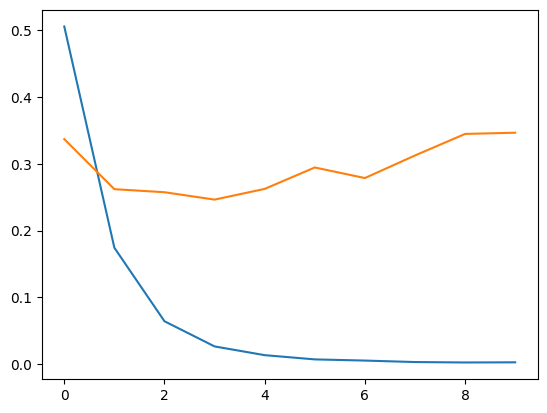

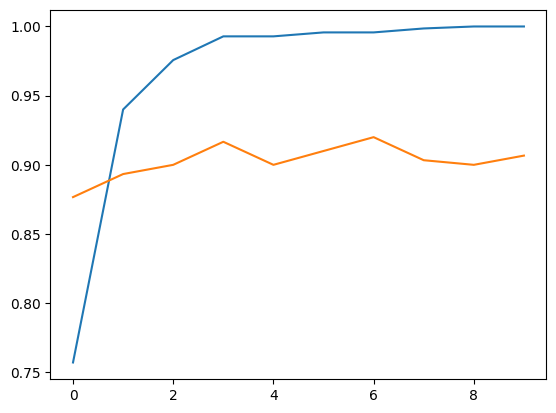

In [20]:
import matplotlib.pyplot as plt
plt.plot(r.history["loss"])
plt.plot(r.history['val_loss'])
plt.figure()
plt.plot(r.history["accuracy"])
plt.plot(r.history['val_accuracy'])

In [21]:
nlp_data.isna().sum()

Review       0
Sentiment    0
dtype: int64

In [49]:
reviews = "I recently dined at a restaurant, and it was truly exceptional. From the moment we walked in, the service was attentive, the food was outstanding, and the atmosphere was inviting. It's a place that offers a fantastic culinary experience, whether for a special occasion or a memorable night out. I'm looking forward to my next visit! Thank you, for a wonderful evening."
preds = reviews.lower()
sequences_review = tokenizer.texts_to_matrix(review)
data_review = pad_sequences(sequences_review, maxlen = T)

model.predict([data_review])

27/27 [==============================] - 1s 52ms/step


array([[0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.45345053],
       [0.453

In [30]:
data_review

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [32]:
data_test

array([[   0,    0,    0, ...,   87,  203, 3868],
       [   0,    0,    0, ...,  922,  321,  504],
       [   0,    0,    0, ...,  188,  109,   56],
       ...,
       [   0,    0,    0, ..., 1609,   85,   34],
       [   0,    0,    0, ...,  174,  165,   53],
       [   0,    0,    0, ...,  427,  414,  549]], dtype=int32)

In [36]:
nlp_data.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1711, 1714, 1715, 1716, 1718, 1719, 1720, 1721, 1722, 1724],
           dtype='int64', length=1000)

In [47]:
review = df.loc[~(df["Review"].isin(nlp_data.Review.to_list()))].Review.to_list()[0]
review = review.lower()

In [50]:
data_review

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)